In [2]:
!pip install PyDrive

    100% |████████████████████████████████| 993kB 17.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1kQg365G6J5uS4Y6GpRaGSEXJCuvEaTGO'})
#https://drive.google.com/open?id=1kQg365G6J5uS4Y6GpRaGSEXJCuvEaTGO
download.GetContentFile('dataset.7z')

In [6]:
# Extract dataset.7z
!p7zip -d dataset.7z

!mkdir histograms


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 69783841 bytes (67 MiB)

Extracting archive: dataset.7z
--
Path = dataset.7z
Type = 7z
Physical Size = 69783841
Headers Size = 70116
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      4% 19         4% 1436 - dataset/fine/ape/fine158.png                                         10% 1545 - dataset/fine/ape/fine256.png                                         10% 2321 - dataset/fine/ape/fine955.png                                         14% 2950 - dataset/fine

In [0]:
# Import necessary libraries
%matplotlib inline

import tensorflow as tf
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob, os
import random
import math
import sys
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix
import itertools


In [0]:
# Define names of folders and categories
folders = ['coarse', 'fine', 'real']

categories = {
    'ape': 1,
    'benchvise': 2,
    'cam': 3,
    'cat': 4,
    'duck': 5
}

In [9]:
# Load whole data
train_set = []
template_set = []
test_set = []

train_pose_set = []
template_pose_set = []
test_pose_set = []

# Extracts pose string into (name, pose) tupple
def extract_pose(pose_str):
    name_val = pose_str.split('\n')
    name = name_val[0].strip()
    quartenion_vals = [float(val) for val in name_val[1].split(' ')]
    
    return (name, quartenion_vals)

# Real data consists of 2 parts, one for training one for test
# Read to get file names for training part
with open('dataset/real/training_split.txt', 'r') as real_split_file:
    real_split = real_split_file.read()
    real_split = real_split.split(', ')
    real_split[-1] = real_split[-1].replace('\n', '')

# Go over folder 
for folder in folders:
    # Go over categories
    for cat_idx, category in enumerate(categories):
        # Read all poses for all files inside 'folder/category/'
        poses_path = os.path.join('dataset', folder, category, 'poses.txt')
        with open(poses_path, 'r') as poses_file:
            all_poses = poses_file.read().split('#')[1:]
            all_poses = dict(map(extract_pose, all_poses))
        
        path = os.path.join('dataset', folder, category, '*.png')
        files = glob.glob(path)
        
        # Real data has 2 parts
        if folder == 'real':
            images_train = []
            images_test = []
            poses_train = []
            poses_test = []
        else:
            images = []
            poses = []
            
        # Read process all images in folder
        for filename in files:
            # Read-Normalize image from [0, 255] to [-1, 1]
            image = mpimg.imread(filename)
            # normalize
            image = 2 * (image / 255) - 1
            
            # Retrieve pose
            # ex: dataset/coarse/ape/coarse191.png
            pose = all_poses[filename.split('/')[-1]]
            
            if folder == 'real':
                if any(index in filename for index in real_split): 
                    images_train.append(image)
                    poses_train.append(pose)
                else:
                    images_test.append(image)
                    poses_test.append(pose)
            else:
                images.append(image)
                poses.append(pose)
        
        # Append current image/pose to corresponding dataset
        if folder == 'coarse':
            template_set.append(images)
            template_pose_set.append(poses)
        elif folder == 'fine':
            train_set.append(images)
            train_pose_set.append(poses)
        elif folder == 'real':
            train_set[cat_idx] += images_train
            train_pose_set[cat_idx] += poses_train
            test_set.append(images_test)
            test_pose_set.append(poses_test)

# Convert datasets to Numpy arrays
train_set = np.array(train_set)
template_set = np.array(template_set)
test_set = np.array(test_set)

train_pose_set = np.array(train_pose_set)
template_pose_set = np.array(template_pose_set)
test_pose_set = np.array(test_pose_set)

template_set_flat = template_set.reshape(-1, 64, 64, 3)
template_pose_set_flat = template_pose_set.reshape(-1, 4)

test_set_flat = test_set.reshape(-1, 64, 64, 3)
test_pose_set_flat = test_pose_set.reshape(-1, 4)

print("Training Set Shape: ", train_set.shape)
print("Template Set Shape: ", template_set.shape)
print("Test Set Shape: ", test_set.shape)
print()
print("Training Pose Set Shape: ", train_pose_set.shape)
print("Template Pose Set Shape: ", template_pose_set.shape)
print("Test Pose Set Shape: ", test_pose_set.shape)

Training Set Shape:  (5, 2148, 64, 64, 3)
Template Set Shape:  (5, 267, 64, 64, 3)
Test Set Shape:  (5, 41, 64, 64, 3)

Training Pose Set Shape:  (5, 2148, 4)
Template Pose Set Shape:  (5, 267, 4)
Test Pose Set Shape:  (5, 41, 4)


In [0]:
# Calculates angular difference between 2 quarternions (in degrees)
def calculate_angle_between(pose1, pose2):

    dot_product = abs(np.dot(np.array(pose1), np.array(pose2)))

    # To ensure numerical stability
    dot_product = round(dot_product, 4)

    degree = 2 * math.acos(dot_product)
    degree = math.degrees(degree)
    return degree

In [0]:
# Batch generator for generating batches on runtime
# This way data won't blow up memory
def batch_generator(batch_size=32):
    while True:
        # Anchor categories and indices
        batch_categories =  np.random.randint(5, size=batch_size)
        category_indices = np.random.randint(train_set.shape[1], size=batch_size)

        batch = []
        for idx in range(batch_size):
            # Retrieve anchor and pose
            category = batch_categories[idx]
            index = category_indices[idx]
            anchor = train_set[category][index]
            anchor_pose = train_pose_set[category][index]

            # Select puller which is very similar to anchor
            min_similarity = sys.maxsize
            for template_idx, template_pose in enumerate(template_pose_set[category]):
                # Get rotation degree between poses
                similarity = calculate_angle_between(anchor_pose, template_pose)

                # 0.1 to ensure poses are not the same
                if similarity < min_similarity and similarity > 0.1:
                    min_similarity = similarity
                    puller = template_set[category][template_idx]

            # Pusher can be:
            # either from the same category (but different pose)
            # or different category
            pusher_is_same_category = random.choice([True, False])
            if pusher_is_same_category: # same category different pose
                pusher_category = category
                pusher_idx = np.random.randint(len(template_set[category])) 
                while pusher_idx == index: # ensure pusher_idx not same as anchor
                    pusher_idx = np.random.randint(len(template_set[category]))
            else: # randomly chosen different category
                pusher_category = np.random.randint(5)
                while pusher_category == category:  # ensure pusher_category not same as anchor
                    pusher_category = np.random.randint(5)
                pusher_idx = np.random.randint(len(template_set[pusher_category]))
                
            # Retrieve pusher
            pusher = template_set[pusher_category][pusher_idx]

            # Append triple to batch
            batch.append(anchor)
            batch.append(puller)
            batch.append(pusher)
        
        # Yield batch
        yield np.array(batch)


In [0]:
def conv_net(x):  
    # First Convolutional layer + ReLU + MaxPool
    conv1 = tf.layers.conv2d(
      inputs=x,
      filters=16,
      kernel_size=[8, 8],
      padding="VALID",
      use_bias=True,
      activation=tf.nn.relu)
    
    pool1 = tf.layers.max_pooling2d(
      inputs=conv1, 
      pool_size=[2, 2], 
      strides=2,
      padding='VALID'
    )
    
    # Second Convolutional layer + ReLU + MaxPool
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=7,
      kernel_size=[5, 5],
      padding="VALID",
      use_bias=True,
      activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(
      inputs=conv2, 
      pool_size=[2, 2], 
      strides=2,
      padding='VALID'
    )

    # Flatten
    fc1 = tf.reshape(pool2, [-1, 12 * 12 * 7])
    
    # First Fully Connected layer + ReLU
    fc1 = tf.layers.dense(
      inputs=fc1, 
      units=256, 
      activation=tf.nn.relu,
      use_bias=True
    )
    
    # Second Fully Connected layer
    fc2 = tf.layers.dense(
      inputs=fc1, 
      units=16, 
      use_bias=True
    )
    return fc2

In [0]:
# Measure model accuracy based on Template and Test Sets
def measure_model_acc(template_predictions, test_predictions):
    # Build NearestNeighbors model
    nearest_neighbor = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(template_predictions)
  
    # Get nearest neighbor of each test sample
    distances, nearest_indices = nearest_neighbor.kneighbors(test_predictions)

    num_correct_class = 0

    # 10, 20, 40, 180
    angles = [0, 0, 0, 0]
    
    #y_test and y_pred will be later used for "Confusion Matrix"
    y_test=[]
    y_pred=[]

    for idx, nearest_index in enumerate(nearest_indices):
        # Get neighbor classes
        test_class = idx // test_set.shape[1]
        nearest_index_class = nearest_index // template_set.shape[1]
        
        y_test.append(test_class)
        y_pred.append(nearest_index_class)

        # Only consider correctly classified classes
        if test_class == nearest_index_class:
            num_correct_class += 1

            # Angular difference between neighbors
            test_pose = test_pose_set_flat[idx]
            template_pose = template_pose_set_flat[nearest_index][0]
            angle = calculate_angle_between(test_pose, template_pose)

            # For histogram
            if angle <= 10:
                angles[0] += 1

            if angle <= 20:
                angles[1] += 1

            if angle <= 40:
                angles[2] += 1

            if angle <= 180:
                angles[3] += 1

    # Finalize computations
    accuracy = num_correct_class / test_set_flat.shape[0] 
    angles = np.array(angles) / test_set_flat.shape[0]

    return (accuracy, angles, y_test, y_pred)

# Plots or saves histogram to a file
def plot_save_histogram(angles, filename=None):
    x = np.arange(4)
    fig, ax = plt.subplots()
    plt.bar(x, angles)
    plt.xticks(x, ('10%', '20%', '40%', '180%'))
    if filename is not None:
        plt.savefig(filename)
        plt.close(fig)
    else:
        plt.show()

In [28]:
# Input for the network
x = tf.placeholder("float", [None, 64,64,3])

# Network parameteres
num_epoch = 30
num_iters = 100
learning_rate = 0.001 
batch_size = 960

# Network output
pred = conv_net(x)

###### Loss computation part 
anchor = pred[0::3]
puller = pred[1::3]
pusher = pred[2::3]

diff_pos = anchor - puller
diff_neg = anchor - pusher

loss_triplets = tf.reduce_sum(tf.maximum(float(0), 1 - (tf.reduce_sum(tf.square(diff_neg), -1) / (tf.reduce_sum(tf.square(diff_pos), -1) + 0.01))))
loss_pairs = tf.reduce_sum(tf.reduce_sum(tf.square(diff_pos), -1))

cost = loss_triplets + loss_pairs
#########

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    # History holders
    loss_history_train = []
    loss_history_val = []
    accuracy_history_test = []
    
    iter_cnt = 0
    for i in range(num_epoch): # For each epoch
        for batch_i in range(num_iters): # For each batch
            iter_cnt += 1
            # Get next batch
            batch_x = next(batch_generator(batch_size))
            
            # Run optimizer
            opt = sess.run(optimizer, feed_dict={x: batch_x})
            
            if iter_cnt % 10 == 0:
                # Print train and validation losses
                train_loss = sess.run(cost, feed_dict={x: batch_x})
                loss_history_train.append(train_loss)
                
                val_x = next(batch_generator(batch_size))
                val_loss = sess.run(cost, feed_dict={x: val_x})
                loss_history_val.append(val_loss)
                
                print(iter_cnt, ": Train Loss: ", train_loss)
                print(iter_cnt, ": Validation Loss: ", val_loss)
            
            if iter_cnt % 500 == 0:
                # Build and save histogram
                pred_template = sess.run(pred, feed_dict={x: template_set_flat})
                pred_test = sess.run(pred, feed_dict={x: test_set_flat})
                (test_acc, angles, c_test, c_pred) = measure_model_acc(pred_template, pred_test)
                y_test=c_test
                y_pred=c_pred
                print("Accuracy: ", test_acc)
                plot_save_histogram(angles, "histograms/hist_" + str(iter_cnt) + ".png")
                accuracy_history_test.append(test_acc)
            
        print("Epoch end!")
        
    tf.train.Saver().save(sess, "./model/model.ckpt")
        

10 : Train Loss:  422.17032
10 : Validation Loss:  417.6023
20 : Train Loss:  348.23395
20 : Validation Loss:  342.05423
30 : Train Loss:  246.33673
30 : Validation Loss:  248.6211
40 : Train Loss:  197.26929
40 : Validation Loss:  188.22516
50 : Train Loss:  161.58063
50 : Validation Loss:  162.10687
60 : Train Loss:  143.16205
60 : Validation Loss:  158.93982
70 : Train Loss:  130.82178
70 : Validation Loss:  133.23961
80 : Train Loss:  110.886566
80 : Validation Loss:  127.96212
90 : Train Loss:  106.716835
90 : Validation Loss:  112.56771
100 : Train Loss:  105.3072
100 : Validation Loss:  111.90497
Epoch end!
110 : Train Loss:  100.01519
110 : Validation Loss:  100.94058
120 : Train Loss:  97.14082
120 : Validation Loss:  96.50322
130 : Train Loss:  94.64351
130 : Validation Loss:  80.747955
140 : Train Loss:  97.53081
140 : Validation Loss:  85.02563
150 : Train Loss:  93.416
150 : Validation Loss:  72.5509
160 : Train Loss:  82.98371
160 : Validation Loss:  96.3072
170 : Train L

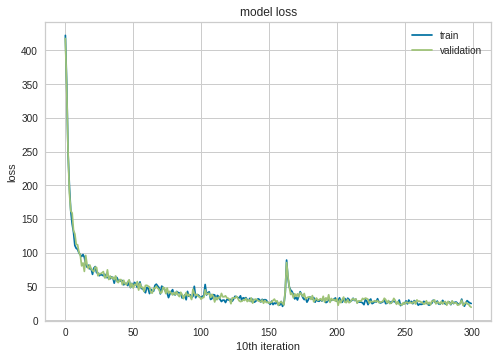

In [29]:
# summarize history for loss
plt.plot(loss_history_train)
plt.plot(loss_history_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel("10th iteration")
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig("loss_history.png")
plt.show()

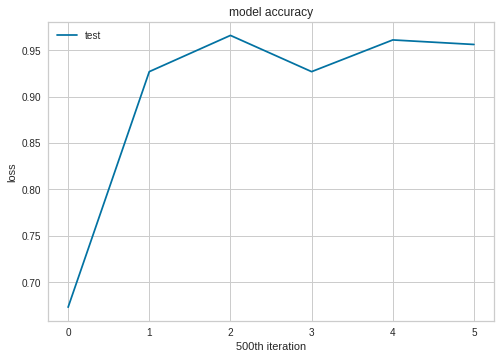

In [30]:
# summarize history for loss
plt.plot(accuracy_history_test)
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel("500th iteration")
plt.legend(['test'], loc='upper left')
plt.savefig("accuracy history.png")
plt.show()

<Figure size 1080x720 with 0 Axes>

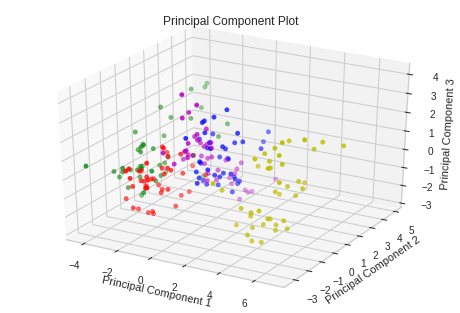

In [31]:
from yellowbrick.features.pca import PCADecomposition
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette

# get color for all classes
pallette = color_palette("reset")
colors = list(map(lambda idx: pallette[idx // test_set.shape[1]], range(len(pred_test))))

visualizer = PCADecomposition(scale=True, proj_dim=3, color = colors, size=(1080, 720))
visualizer.fit_transform(pred_test, colors)
visualizer.poof(outpath="./pca", dpi=300)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig("Confusion_Matrix.png")

[0, 0, 0, 0, 0, 0]
Normalized confusion matrix
[[92.68  0.    0.    4.88  2.44]
 [ 0.   95.12  4.88  0.    0.  ]
 [ 0.    2.44 97.56  0.    0.  ]
 [ 2.44  0.    0.   97.56  0.  ]
 [ 4.88  0.    0.    0.   95.12]]


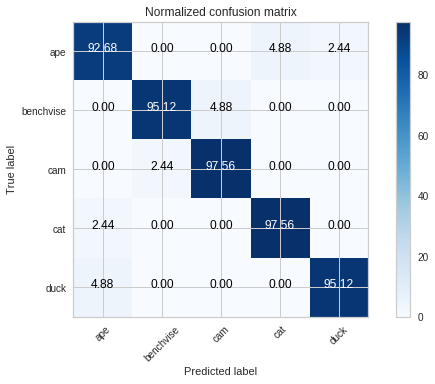

In [33]:
print(y_test[:6])
y_test=np.array(y_test)
y_pred=np.array(y_pred)

class_names=["ape","benchvise","cam","cat","duck"]
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()